In [1]:
pip install pyts;

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Usuario\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install h5py;
!pip install pandas;

In [3]:
pip install pandas;

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Usuario\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Usuario\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [197]:
pip install matplotlib


     ---------------------------------------- 7.8/7.8 MB 118.7 kB/s eta 0:00:00
     ------------------------------------ 104.1/104.1 KB 214.8 kB/s eta 0:00:00
     ------------------------------------ 216.0/216.0 KB 274.4 kB/s eta 0:00:00
     -------------------------------------- 55.9/55.9 KB 585.1 kB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 214.0 kB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 128.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Usuario\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [199]:
pip install seaborn


     ------------------------------------ 294.9/294.9 KB 865.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Usuario\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
#carga de archivos

test_name = "test.h5"
train_name = "train.h5"

In [201]:
import h5py
import numpy as np
import pandas as pd
import pyts
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from pyts.transformation import WEASEL
from pyts.transformation import BOSS
from sklearn.metrics import accuracy_score, f1_score

with h5py.File(train_name, 'r') as file:
    dataset_names_train = list(file.keys())
    print("Available datasets train:", dataset_names_train)

with h5py.File(train_name, 'r') as file:
    eeg_data = file['x'][:]  
    data = np.reshape(eeg_data[:], (eeg_data.shape[0], -1))
    df = pd.DataFrame(data)
    labels = file['y'][:]    
    data2 = np.reshape(labels[:], (labels.shape[0], -1))
    df2 = pd.DataFrame(data2)



Available datasets train: ['x', 'y']


In [96]:
# Elimina las dimensiones de tamaño 1
data_squeezed = np.reshape(eeg_data, (eeg_data.shape[0], -1))

print(data_squeezed.shape)

(204, 18530)


In [97]:
#Algoritmo de SVM no lineal

class SVMNonLinear:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, gamma=0.1, C=1.0):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param 
        self.n_iters = n_iters
        self.gamma = gamma  
        self.C = C          
        self.alpha = None    
        self.b = None        
        self.X_train = None  
        self.y_train = None  

    def rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def fit(self, X, y):
        y_ = np.where(y == 0, -1, 1) # hacemos el cambio de 0 a -1 ya que SVM trabaja con ese parametro
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.b = 0
        self.X_train = X
        self.y_train = y_

        for _ in range(self.n_iters):
            for i in range(n_samples):
                condition = y_[i] * (np.sum(self.alpha * y_ * self._rbf_sum(X[i])) - self.b) >= 1
                if condition:
                    self.alpha[i] -= self.learning_rate * (2 * self.lambda_param * self.alpha[i])
                else:
                    self.alpha[i] += self.learning_rate * y_[i]
                    self.b -= self.learning_rate * y_[i]

    def _rbf_sum(self, x_i):
        return np.array([self.rbf_kernel(x_i, x_j) for x_j in self.X_train])

    def predict(self, X):
        y_pred = []
        for x in X:
            pred = np.sum(self.alpha * self.y_train * self._rbf_sum(x)) - self.b
            y_pred.append(np.sign(pred))
        return np.where(np.array(y_pred) == -1, 0, 1) #volvemos a cambiar el parametro ahora de -1 a 0


In [178]:
X_train, X_test, y_train, y_test = train_test_split(data_squeezed, labels, test_size=0.2, random_state=42)

print("X_train Shape:", X_train.shape) 
print("X_test Shape:", X_test.shape)    
print("y_train Shape:", y_train.shape)  
print("y_test Shape:", y_test.shape)

X_train Shape: (163, 18530)
X_test Shape: (41, 18530)
y_train Shape: (163,)
y_test Shape: (41,)


In [179]:
#smote pruebaaaaaaaaaaa
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [181]:
pca = PCA(n_components=47)
data_pca = pca.fit_transform(X_res)
X_train_pca= np.asarray(data_pca)
X_test_pca = pca.transform(X_test)

# Imprimir las formas después de aplicar PCA
print("X_train Shape después de PCA:", X_train_pca.shape) 
print("X_test Shape después de PCA:", X_test_pca.shape)

X_train Shape después de PCA: (238, 47)
X_test Shape después de PCA: (41, 47)


In [183]:
#Boss
boss = BOSS()
X_train_boss = boss.fit_transform(X_train_pca, y_res)
X_test_boss = boss.transform(X_test_pca)

print("X_train BOSS Shape:", X_train_boss.shape)
print("X_test BOSS Shape:", X_test_boss.shape)

#Cambiar de dispersa a densa
X_train_Boss_dense = np.asarray(X_train_boss.todense())
X_test_Boss_dense = np.asarray(X_test_boss.todense())

print("X_train Boss Shape:", X_train_Boss_dense.shape)
print("X_test Boss Shape:", X_test_Boss_dense.shape)

X_train BOSS Shape: (238, 256)
X_test BOSS Shape: (41, 256)
X_train Boss Shape: (238, 256)
X_test Boss Shape: (41, 256)


In [186]:
#Pruebas con SVM implementado por nosotros usando Boss

svm_nl = SVMNonLinear(learning_rate=0.001, lambda_param=0.01, n_iters=1000, gamma=0.1)
svm_nl.fit(X_train_Boss_dense, y_res)
print(y_train)
y_pred_l = svm_nl.predict(X_test_Boss_dense)
print("Predicciones completas:", y_pred_l)

accuracy_l = accuracy_score(y_test, y_pred_l)
f1_l = f1_score(y_test, y_pred_l, average='weighted')

print(f"Accuracy : {accuracy_l}")
print(f"F1-Score : {f1_l}")

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1
 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1
 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0]
Predicciones completas: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0]
Accuracy : 0.6829268292682927
F1-Score : 0.5938494167550371


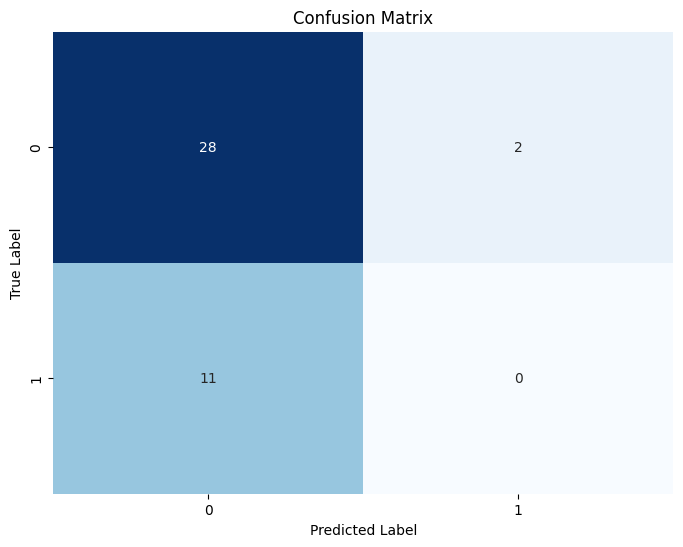

In [200]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_l)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [187]:
## sacar ahora con el test.h5
with h5py.File(test_name, 'r') as file:
    eeg_data_test = file['x'][:]  
    data = np.reshape(eeg_data_test[:], (eeg_data_test.shape[0], -1))
    df_t = pd.DataFrame(data)

print("EEG Data Shape:", eeg_data_test.shape)  

print(df_t.head())
print(df_t.info())

EEG Data Shape: (205, 1, 18530)
      0         1         2         3         4         5         6      \
0  0.029938  0.061432  0.072388  0.081329  0.078033  0.089691  0.071564   
1  0.000275  0.001160  0.001556  0.001740  0.002380  0.003693  0.004883   
2 -0.002899 -0.003510  0.000458  0.002991  0.005920  0.007355  0.008728   
3  0.008636  0.018158  0.015717  0.015991  0.015442  0.015564  0.014679   
4 -0.011475 -0.022217 -0.017456 -0.018890 -0.019714 -0.021301 -0.025055   

      7         8         9      ...     18520     18521     18522     18523  \
0  0.072205  0.062988  0.057098  ... -0.000580  0.001617  0.003540  0.003662   
1  0.005310  0.005676  0.005310  ...  0.013000  0.009399  0.005981  0.001801   
2  0.008698  0.007507  0.005341  ... -0.014679 -0.019745 -0.022583 -0.023346   
3  0.014923  0.013916  0.014008  ...  0.007874  0.006989  0.006531  0.006012   
4 -0.033569 -0.039215 -0.038483  ...  0.007263  0.008270  0.010071  0.012146   

      18524     18525     18526     

In [188]:
# Elimina las dimensiones de tamaño 1
data_squeezed_t = np.reshape(eeg_data_test, (eeg_data_test.shape[0], -1))

print(data_squeezed_t.shape)

(205, 18530)


In [192]:
pca = PCA(n_components=47)  
X_test_pca_t = pca.fit_transform(data_squeezed_t)
X_test_pca_t= np.asarray(X_test_pca_t)
print(X_test_pca_t.shape)


(205, 47)


In [193]:
#Boss
boss = BOSS()
X_test_boss_t = boss.fit_transform(X_test_pca_t)
#Cambiar de dispersa a densa
X_test_Boss_dense_t = np.asarray(X_test_boss_t.todense())

print("X_test Boss Shape:", X_test_Boss_dense_t.shape)    

X_test Boss Shape: (205, 256)


In [194]:
y_pred_t = svm_nl.predict(X_test_Boss_dense_t)

# Mostrar las predicciones
print("Predicciones:", y_pred_t)


Predicciones: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [169]:
submission = pd.DataFrame({
    'ID':  np.arange(1, len(y_pred_t) + 1),  
    'result': y_pred_t  
})

submission.to_csv('submission2.csv', index=False)

print("Archivo submission.csv creado con éxito.")

Archivo submission.csv creado con éxito.


In [225]:

learning_rates = [0.01, 0.001]
lambda_params = [0.1, 0.01, 0.001]
gammas = [0.01, 0.1]
n_iters_values = [1000, 2000]

best_params = {}
best_accuracy = 0

for lr in learning_rates:
    for lam in lambda_params:
        for gamma in gammas:
            for n_iters in n_iters_values:
                svm_nl = SVMNonLinear(learning_rate=lr, lambda_param=lam, n_iters=n_iters, gamma=gamma)
                svm_nl.fit(X_train_Boss_dense, y_train)
                
                y_pred_l = svm_nl.predict(X_test_Boss_dense)
                accuracy_l = accuracy_score(y_test, y_pred_l)
                print(f"Parámetros: lr={lr}, lambda={lam}, gamma={gamma}, n_iters={n_iters} -> Accuracy: {accuracy_l}")
                
                if accuracy_l > best_accuracy:
                    best_accuracy = accuracy_l
                    best_params = {
                        'learning_rate': lr,
                        'lambda_param': lam,
                        'gamma': gamma,
                        'n_iters': n_iters
                    }

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor accuracy: {best_accuracy}")


Parámetros: lr=0.01, lambda=0.1, gamma=0.01, n_iters=1000 -> Accuracy: 0.3170731707317073
Parámetros: lr=0.01, lambda=0.1, gamma=0.01, n_iters=2000 -> Accuracy: 0.3170731707317073
Parámetros: lr=0.01, lambda=0.1, gamma=0.1, n_iters=1000 -> Accuracy: 0.6341463414634146
Parámetros: lr=0.01, lambda=0.1, gamma=0.1, n_iters=2000 -> Accuracy: 0.6341463414634146
Parámetros: lr=0.01, lambda=0.01, gamma=0.01, n_iters=1000 -> Accuracy: 0.2926829268292683
Parámetros: lr=0.01, lambda=0.01, gamma=0.01, n_iters=2000 -> Accuracy: 0.3170731707317073
Parámetros: lr=0.01, lambda=0.01, gamma=0.1, n_iters=1000 -> Accuracy: 0.6341463414634146
Parámetros: lr=0.01, lambda=0.01, gamma=0.1, n_iters=2000 -> Accuracy: 0.6341463414634146
Parámetros: lr=0.01, lambda=0.001, gamma=0.01, n_iters=1000 -> Accuracy: 0.2682926829268293
Parámetros: lr=0.01, lambda=0.001, gamma=0.01, n_iters=2000 -> Accuracy: 0.3170731707317073
Parámetros: lr=0.01, lambda=0.001, gamma=0.1, n_iters=1000 -> Accuracy: 0.6341463414634146
Parám

KeyboardInterrupt: 